# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [ ]:
help(BinaryClassificationPerformance)

# Function for feature building and extraction on natural language data

In [2]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 5 rows in toxic_data:")
    print(toxic_data.head(5))

    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 14, alternate_sign=False, ngram_range=(1,2), token_pattern=r'\b\w+\b', stop_words='english')       
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    # submission condition is test: what's the diff between test and not test here?  
    # 'fitted_transformations.append' vs. '.transform'.  Why in the test condition does transform the data
    # "fit" computes the mean and std to be used for later scaling. (just a computation) 
    # "transform" uses a previously computed mean and std to autoscale the data
        
    if (not test):
        chv = HashingVectorizer(n_features=2 ** 14, alternate_sign=False, analyzer='char_wb', ngram_range=(2,4))
        X_chv = chv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(chv)
        print("Shape of HashingVectorizer char n_gram X:")
        print(X_chv.shape)
    else:
        X_chv = fitted_transformations[1].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer char n_gram X:")
        print(X_chv.shape)
    
#     X_cv = hstack([X_hv, X_chv])
#     print("Shape of Vectorizer combined X:")
#     print(X_cv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
#     if (not test):
#         transformer = TfidfTransformer()
#         X_tfidf = transformer.fit_transform(X_cv)
#         fitted_transformations.append(transformer)
#     else:
#         X_tfidf = fitted_transformations[1].transform(X_cv)
    
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[2].transform(X_hv)

    # character n-grams   
    if (not test):
        transformer_chv = TfidfTransformer()
        X_tfidf_chv = transformer_chv.fit_transform(X_chv)
        fitted_transformations.append(transformer_chv)
    else:
        X_tfidf_chv = fitted_transformations[3].transform(X_chv)
    
    # create additional quantitative features

    # what does the form toxic_data['comment_text'] mean?
    toxic_data['char_count'] = toxic_data['comment_text'].str.len()
    toxic_data['Caps_count'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    toxic_data['Caps_ratio'] = pow((toxic_data['Caps_count']+1)/toxic_data['char_count'], 3)
    
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['char_ratio'] = toxic_data['char_count']/toxic_data['word_count']
    
    toxic_data['punc_count_p'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['punc_count_exc'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['punc_count_q'] = toxic_data['comment_text'].str.count("\?")
    toxic_data['punc_count_c'] = toxic_data['comment_text'].str.count("\,")
    toxic_data['punc_count_a'] = toxic_data['comment_text'].str.count("\*")
    toxic_data['punc_count_s'] = toxic_data['comment_text'].str.count("\;")
    
    toxic_data['punc_count'] = toxic_data['punc_count_s'] + toxic_data['punc_count_a'] + toxic_data['punc_count_c'] + toxic_data['punc_count_p'] + toxic_data['punc_count_exc'] + toxic_data['punc_count_q']
    toxic_data['punc_ratio'] = toxic_data['punc_count']/toxic_data['word_count']
    toxic_data['punc_exc_ratio'] = (toxic_data['punc_count_exc']+0.1) / (toxic_data['punc_count']+0.1)
    toxic_data['punc_q_ratio'] = (toxic_data['punc_count_q']+0.1) / (toxic_data['punc_count']+0.1)
    
    toxic_data['Capsword_ratio'] = (toxic_data['Caps_count'] + toxic_data['punc_count'])/toxic_data['word_count']
    
    toxic_data['spaces_count'] = toxic_data['comment_text'].str.count(" ")
    toxic_data['spaces_ratio'] = toxic_data['spaces_count']/toxic_data['char_count']
    toxic_data['spaceswords_ratio'] = toxic_data['spaces_count']/toxic_data['word_count']
    
    # count the number of consecutive caps letters
    toxic_data['consCaps_count'] = toxic_data['comment_text'].str.count(r'[A-Z]{3}')
    toxic_data['consCaps_ratio'] = toxic_data['consCaps_count']/toxic_data['char_count']
    toxic_data['consCapsword_ratio'] = toxic_data['consCaps_count']/toxic_data['word_count']
    
#     toxic_data['word_count_f'] =(toxic_data['comment_text'].str.lower().str.count("fuck"))
#     toxic_data['word_count_s'] =(toxic_data['comment_text'].str.lower().str.count("shit"))
#     toxic_data['word_count_h'] =(toxic_data['comment_text'].str.lower().str.count("hell"))
    
    # current count: 22 quant features
    X_quant_features = toxic_data[["punc_q_ratio", "punc_exc_ratio", "punc_count_s", "punc_count_a", "punc_count_c", "consCapsword_ratio", "consCaps_ratio", "consCaps_count", "spaceswords_ratio", "spaces_ratio", "spaces_count", "char_count", "Caps_count", "Caps_ratio", "word_count", "char_ratio", "punc_count_p", "punc_count_exc", "punc_count_q", "punc_count", "punc_ratio", "Capsword_ratio"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
#     X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_combined = hstack([X_tfidf, X_tfidf_chv, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[4].transform(X_matrix)
        print(X.shape)
    

#     # polynomialregression
#     if (not test):
#         poly = PolynomialFeatures(degree=2, interaction_only=True, order='F')
#         X = poly.fit_transform(X_matrix)
#         fitted_transformations.append(poly)
#         print(X.shape)
#         y = toxic_data['any_toxic']
#     else:
#         X = fitted_transformations[4].transform(X_matrix)
#         print(X.shape)
    
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [3]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_train.csv', my_random_seed=36)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 5 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0      

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [182]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)
print("False Positive Rate:")
print(ols_performance_train.performance_measures['FP'] / ols_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_train.performance_measures['TP'] / ols_performance_train.performance_measures['Pos'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


{'Pos': 12951, 'Neg': 114705, 'TP': 6811, 'TN': 53846, 'FP': 60859, 'FN': 6140, 'Accuracy': 0.47515980447452527, 'Precision': 0.10065021427515886, 'Recall': 0.5259053354953286, 'desc': 'ols_train'}
False Positive Rate:
0.5305697223311974
True Positive Rate:
0.5259053354953286


### MODEL: SVM, linear

In [252]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)
print("False Positive Rate:")
print(svm_performance_train.performance_measures['FP'] / svm_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_train.performance_measures['TP'] / svm_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12930, 'TN': 114651, 'FP': 54, 'FN': 21, 'Accuracy': 0.9994124835495394, 'Precision': 0.9958410351201479, 'Recall': 0.9983785035904563, 'desc': 'svm_train'}
False Positive Rate:
0.0004707728520988623
True Positive Rate:
0.9983785035904563


### MODEL: logistic regression

In [253]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)
print("False Positive Rate:")
print(lgs_performance_train.performance_measures['FP'] / lgs_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_train.performance_measures['TP'] / lgs_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12931, 'TN': 114687, 'FP': 18, 'FN': 20, 'Accuracy': 0.9997023249984333, 'Precision': 0.9986099312688238, 'Recall': 0.9984557177051965, 'desc': 'lgs_train'}
False Positive Rate:
0.0001569242840329541
True Positive Rate:
0.9984557177051965


### MODEL: Naive Bayes

In [18]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)
print("False Positive Rate:")
print(nbs_performance_train.performance_measures['FP'] / nbs_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(nbs_performance_train.performance_measures['TP'] / nbs_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 11339, 'TN': 103400, 'FP': 11305, 'FN': 1612, 'Accuracy': 0.8988140001253369, 'Precision': 0.5007507507507507, 'Recall': 0.8755308470388387, 'desc': 'nbs_train'}
False Positive Rate:
0.09855716838847478
True Positive Rate:
0.8755308470388387


### MODEL: Perceptron

In [254]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)
print("False Positive Rate:")
print(prc_performance_train.performance_measures['FP'] / prc_performance_train.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_train.performance_measures['TP'] / prc_performance_train.performance_measures['Pos'])

{'Pos': 12951, 'Neg': 114705, 'TP': 12914, 'TN': 114623, 'FP': 82, 'FN': 37, 'Accuracy': 0.9990678072319358, 'Precision': 0.9936903662665435, 'Recall': 0.9971430777546135, 'desc': 'prc_train'}
False Positive Rate:
0.000714877293927902
True Positive Rate:
0.9971430777546135


### MODEL: Ridge Regression Classifier

In [102]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'tr0')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12487, 'TN': 114655, 'FP': 50, 'FN': 464, 'Accuracy': 0.9959735539261766, 'Precision': 0.9960118050570312, 'Recall': 0.964172650760559, 'desc': 'tr0'}


In [19]:
from sklearn import linear_model
rdg1 = linear_model.RidgeClassifier(alpha=10)
rdg1.fit(X_train, y_train)

rdg_performance_train_1 = BinaryClassificationPerformance(rdg1.predict(X_train), y_train, 'tr1')
rdg_performance_train_1.compute_measures()
print(rdg_performance_train_1.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12465, 'TN': 114656, 'FP': 49, 'FN': 486, 'Accuracy': 0.9958090493200477, 'Precision': 0.9960843854882532, 'Recall': 0.9624739402362752, 'desc': 'tr1'}


In [20]:
from sklearn import linear_model
rdg2 = linear_model.RidgeClassifier(alpha=100)
rdg2.fit(X_train, y_train)

rdg_performance_train_2 = BinaryClassificationPerformance(rdg2.predict(X_train), y_train, 'tr2')
rdg_performance_train_2.compute_measures()
print(rdg_performance_train_2.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12452, 'TN': 114656, 'FP': 49, 'FN': 499, 'Accuracy': 0.9957072131353011, 'Precision': 0.996080313574914, 'Recall': 0.961470156744653, 'desc': 'tr2'}


In [21]:
from sklearn import linear_model
rdg5 = linear_model.RidgeClassifier(alpha=100000)
rdg5.fit(X_train, y_train)

rdg_performance_train_5 = BinaryClassificationPerformance(rdg5.predict(X_train), y_train, 'tr5')
rdg_performance_train_5.compute_measures()
print(rdg_performance_train_5.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 9419, 'TN': 114629, 'FP': 76, 'FN': 3532, 'Accuracy': 0.9717365419565082, 'Precision': 0.9919957872564508, 'Recall': 0.7272797467377037, 'desc': 'tr5'}


In [22]:
from sklearn import linear_model
rdg7 = linear_model.RidgeClassifier(alpha=0.0000001)
rdg7.fit(X_train, y_train)

rdg_performance_train_7 = BinaryClassificationPerformance(rdg7.predict(X_train), y_train, 'tr-7')
rdg_performance_train_7.compute_measures()
print(rdg_performance_train_7.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12466, 'TN': 114656, 'FP': 49, 'FN': 485, 'Accuracy': 0.9958168828727204, 'Precision': 0.9960846983619657, 'Recall': 0.9625511543510153, 'desc': 'tr-7'}


In [31]:
from sklearn import linear_model
rdg9 = linear_model.RidgeClassifier(alpha=0.000000001)
rdg9.fit(X_train, y_train)

rdg_performance_train_9 = BinaryClassificationPerformance(rdg9.predict(X_train), y_train, 'tr-9')
rdg_performance_train_9.compute_measures()
print(rdg_performance_train_9.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12468, 'TN': 114657, 'FP': 48, 'FN': 483, 'Accuracy': 0.9958403835307389, 'Precision': 0.9961649089165868, 'Recall': 0.9627055825804958, 'desc': 'tr-13'}


In [44]:
from sklearn import linear_model
rdg11 = linear_model.RidgeClassifier(alpha=0.00000000001)
rdg11.fit(X_train, y_train)

rdg_performance_train_11 = BinaryClassificationPerformance(rdg11.predict(X_train), y_train, 'tr-11')
rdg_performance_train_11.compute_measures()
print(rdg_performance_train_11.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12465, 'TN': 114656, 'FP': 49, 'FN': 486, 'Accuracy': 0.9958090493200477, 'Precision': 0.9960843854882532, 'Recall': 0.9624739402362752, 'desc': 'tr-11'}


In [31]:
from sklearn import linear_model
rdg13 = linear_model.RidgeClassifier(alpha=0.0000000000001)
rdg13.fit(X_train, y_train)

rdg_performance_train_13 = BinaryClassificationPerformance(rdg13.predict(X_train), y_train, 'tr-13')
rdg_performance_train_13.compute_measures()
print(rdg_performance_train_13.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12468, 'TN': 114657, 'FP': 48, 'FN': 483, 'Accuracy': 0.9958403835307389, 'Precision': 0.9961649089165868, 'Recall': 0.9627055825804958, 'desc': 'tr-13'}


In [45]:
from sklearn import linear_model
rdg19 = linear_model.RidgeClassifier(alpha=0.0000000000000000001)
rdg19.fit(X_train, y_train)

rdg_performance_train_19 = BinaryClassificationPerformance(rdg19.predict(X_train), y_train, 'tr-19')
rdg_performance_train_19.compute_measures()
print(rdg_performance_train_13.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12468, 'TN': 114657, 'FP': 48, 'FN': 483, 'Accuracy': 0.9958403835307389, 'Precision': 0.9961649089165868, 'Recall': 0.9627055825804958, 'desc': 'tr-13'}


### MODEL: Random Forest Classifier

In [52]:
from sklearn.ensemble import RandomForestClassifier
rdf_50 = RandomForestClassifier(n_estimators=50, random_state=0)
# manipulate max_depth
rdf_50.fit(X_train, y_train)

rdf_performance_train_50 = BinaryClassificationPerformance(rdf_50.predict(X_train), y_train, 'rdf_train_50')
rdf_performance_train_50.compute_measures()
print(rdf_performance_train_50.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12914, 'TN': 114704, 'FP': 1, 'FN': 37, 'Accuracy': 0.9997023249984333, 'Precision': 0.9999225706542779, 'Recall': 0.9971430777546135, 'desc': 'rdf_train_50'}


In [51]:
from sklearn.ensemble import RandomForestClassifier
rdf_100 = RandomForestClassifier(max_depth=40, n_estimators=100, random_state=0)
# manipulate max_depth
rdf_100.fit(X_train, y_train)

rdf_performance_train_100 = BinaryClassificationPerformance(rdf_100.predict(X_train), y_train, 'rdf_train_100')
rdf_performance_train_100.compute_measures()
print(rdf_performance_train_100.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 8632, 'TN': 114705, 'FP': 0, 'FN': 4319, 'Accuracy': 0.9661668860061415, 'Precision': 1.0, 'Recall': 0.6665122384371863, 'desc': 'rdf_train_100'}


In [48]:
from sklearn.ensemble import RandomForestClassifier
rdf_150 = RandomForestClassifier(max_depth=40, n_estimators=125, random_state=0)
# manipulate max_depth
rdf_150.fit(X_train, y_train)

rdf_performance_train_150 = BinaryClassificationPerformance(rdf_150.predict(X_train), y_train, 'rdf_train_150')
rdf_performance_train_150.compute_measures()
print(rdf_performance_train_150.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12914, 'TN': 114704, 'FP': 1, 'FN': 37, 'Accuracy': 0.9997023249984333, 'Precision': 0.9999225706542779, 'Recall': 0.9971430777546135, 'desc': 'rdf_train_50'}


In [48]:
from sklearn.ensemble import RandomForestClassifier
rdf_200 = RandomForestClassifier(n_estimators=150, random_state=0)
# manipulate max_depth
rdf_200.fit(X_train, y_train)

rdf_performance_train_200 = BinaryClassificationPerformance(rdf_200.predict(X_train), y_train, 'rdf_train_200')
rdf_performance_train_200.compute_measures()
print(rdf_performance_train_200.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12914, 'TN': 114704, 'FP': 1, 'FN': 37, 'Accuracy': 0.9997023249984333, 'Precision': 0.9999225706542779, 'Recall': 0.9971430777546135, 'desc': 'rdf_train_50'}


### MODEL: Random Forest Classifier

In [6]:
from sklearn.ensemble import RandomForestClassifier
rdf_60 = RandomForestClassifier(max_depth=60, random_state=0)
# manipulate max_depth
rdf_60.fit(X_train, y_train)

rdf_performance_train_60 = BinaryClassificationPerformance(rdf_60.predict(X_train), y_train, 'rdf_train_60')
rdf_performance_train_60.compute_measures()
print(rdf_performance_train_60.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 10637, 'TN': 114705, 'FP': 0, 'FN': 2314, 'Accuracy': 0.9818731591151219, 'Precision': 1.0, 'Recall': 0.8213265384912362, 'desc': 'rdf_train_60'}


In [7]:
from sklearn.ensemble import RandomForestClassifier
rdf_80 = RandomForestClassifier(max_depth=80, random_state=0)
# manipulate max_depth
rdf_80.fit(X_train, y_train)

rdf_performance_train_80 = BinaryClassificationPerformance(rdf_80.predict(X_train), y_train, 'rdf_train_80')
rdf_performance_train_80.compute_measures()
print(rdf_performance_train_80.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 11756, 'TN': 114705, 'FP': 0, 'FN': 1195, 'Accuracy': 0.9906389045559942, 'Precision': 1.0, 'Recall': 0.9077291328854915, 'desc': 'rdf_train_80'}


In [9]:
from sklearn.ensemble import RandomForestClassifier
rdf_100 = RandomForestClassifier(max_depth=100, random_state=0)
# manipulate max_depth
rdf_100.fit(X_train, y_train)

rdf_performance_train_100 = BinaryClassificationPerformance(rdf_100.predict(X_train), y_train, 'rdf_train_100')
rdf_performance_train_100.compute_measures()
print(rdf_performance_train_100.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12493, 'TN': 114705, 'FP': 0, 'FN': 458, 'Accuracy': 0.9964122328758539, 'Precision': 1.0, 'Recall': 0.9646359354490001, 'desc': 'rdf_train_100'}


In [24]:
from sklearn.ensemble import RandomForestClassifier
rdf_120 = RandomForestClassifier(max_depth=120, random_state=0)
# manipulate max_depth
rdf_120.fit(X_train, y_train)

rdf_performance_train_120 = BinaryClassificationPerformance(rdf_120.predict(X_train), y_train, 'rdf_train_120')
rdf_performance_train_120.compute_measures()
print(rdf_performance_train_120.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12761, 'TN': 114705, 'FP': 0, 'FN': 190, 'Accuracy': 0.9985116249921665, 'Precision': 1.0, 'Recall': 0.9853293181993669, 'desc': 'rdf_train_120'}


In [14]:
from sklearn.ensemble import RandomForestClassifier
rdf_140 = RandomForestClassifier(max_depth=140, random_state=0)
# manipulate max_depth
rdf_140.fit(X_train, y_train)

rdf_performance_train_140 = BinaryClassificationPerformance(rdf_140.predict(X_train), y_train, 'rdf_train_140')
rdf_performance_train_140.compute_measures()
print(rdf_performance_train_140.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 12906, 'TN': 114705, 'FP': 0, 'FN': 45, 'Accuracy': 0.9996474901297236, 'Precision': 1.0, 'Recall': 0.9965253648366922, 'desc': 'rdf_train_140'}


In [40]:
from sklearn.ensemble import RandomForestClassifier
rdf_20e = RandomForestClassifier(max_depth=20, criterion="entropy", random_state=0)
# manipulate max_depth
rdf_20e.fit(X_train, y_train)

rdf_performance_train_20e = BinaryClassificationPerformance(rdf_20e.predict(X_train), y_train, 'rdf_train_20e')
rdf_performance_train_20e.compute_measures()
print(rdf_performance_train_20e.performance_measures)

{'Pos': 12951, 'Neg': 114705, 'TP': 5246, 'TN': 114705, 'FP': 0, 'FN': 7705, 'Accuracy': 0.9396424766560131, 'Precision': 1.0, 'Recall': 0.4050652459269555, 'desc': 'rdf_train_20e'}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rdf_140e = RandomForestClassifier(max_depth=140, class_weight="balanced", random_state=0)
# manipulate max_depth
rdf_140e.fit(X_train, y_train)

rdf_performance_train_140e = BinaryClassificationPerformance(rdf_140e.predict(X_train), y_train, 'rdf_train_140e')
rdf_performance_train_140e.compute_measures()
print(rdf_performance_train_140e.performance_measures)

### ROC plot to compare performance of various models and fits

In [ ]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [ ]:
fits = [rdg_performance_train, rdg_performance_train_1, rdg_performance_train_2, rdg_performance_train_7, rdg_performance_train_9, rdg_performance_train_13, rdg_performance_train_19]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0.000415, 0.00043, 0.961, .963])
plt.title('ROC plot Ridge Regression: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### ROC plot: Random Forest Experiment - Training

In [ ]:
# test max_depth
fits = [rdf_performance_train_20, rdf_performance_train_40, rdf_performance_train_60, rdf_performance_train_80, rdf_performance_train_100, rdf_performance_train_120, rdf_performance_train_140]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot Ridge Regression: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.show()

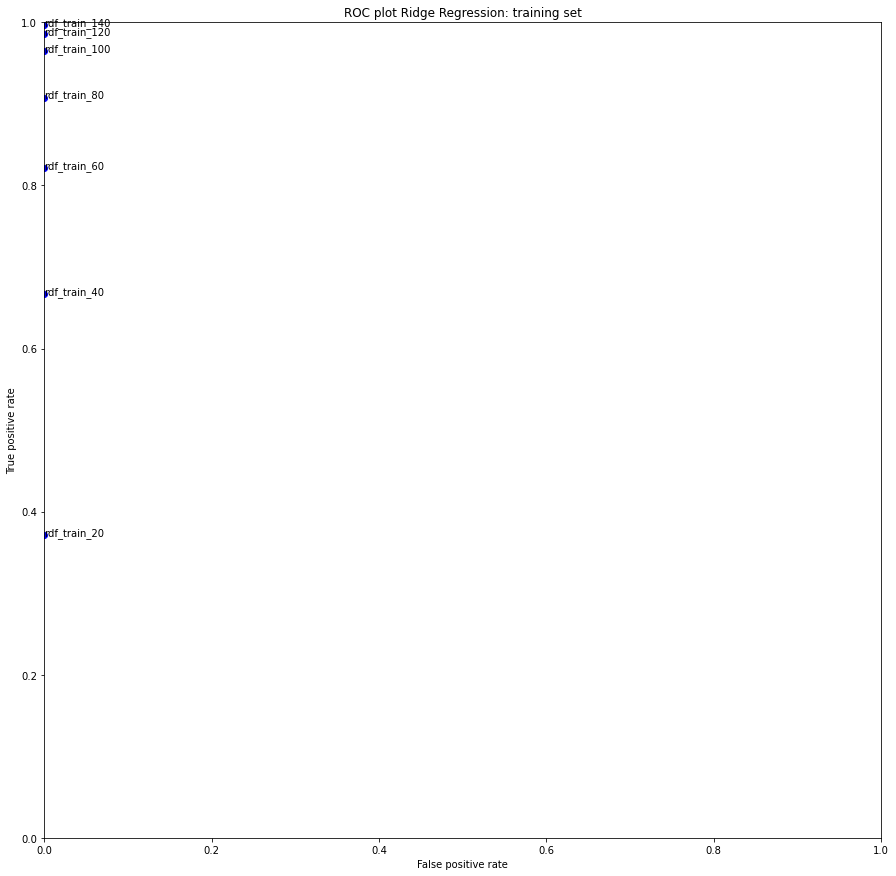

In [31]:
# test criterion
fits = [rdf_performance_train_20, rdf_performance_train_140, rdf_performance_train_20e, rdf_performance_train_140e]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot Ridge Regression: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some examples of classification:

In [ ]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


In [ ]:
# true positives

print("Examples of true positives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


In [ ]:
# false negatives

print("Examples of false negatives:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 0):
    # model predicts negative
        if (X_raw_train.iloc[i]['any_toxic'] == 1):
        # but training data says should have been positive; thus, false negative
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [ ]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)
print("False Positive Rate:")
print(ols_performance_test.performance_measures['FP'] / ols_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(ols_performance_test.performance_measures['TP'] / ols_performance_test.performance_measures['Pos'])

### MODEL: SVM, linear

In [255]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)
print("False Positive Rate:")
print(svm_performance_test.performance_measures['FP'] / svm_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(svm_performance_test.performance_measures['TP'] / svm_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2373, 'TN': 27733, 'FP': 908, 'FN': 901, 'Accuracy': 0.9433181889393703, 'Precision': 0.7232551051508687, 'Recall': 0.724801466096518, 'desc': 'svm_test'}
False Positive Rate:
0.031702803673056106
True Positive Rate:
0.724801466096518


### MODEL: logistic regression

In [256]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)
print("False Positive Rate:")
print(lgs_performance_test.performance_measures['FP'] / lgs_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(lgs_performance_test.performance_measures['TP'] / lgs_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2337, 'TN': 27829, 'FP': 812, 'FN': 937, 'Accuracy': 0.9451981826727244, 'Precision': 0.7421403620196888, 'Recall': 0.7138057422113623, 'desc': 'lgs_test'}
False Positive Rate:
0.02835096539925282
True Positive Rate:
0.7138057422113623


### MODEL: Naive Bayes

In [19]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)
print("False Positive Rate:")
print(nbs_performance_test.performance_measures['FP'] / nbs_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(nbs_performance_test.performance_measures['TP'] / nbs_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2705, 'TN': 25715, 'FP': 2926, 'FN': 569, 'Accuracy': 0.8904903650321165, 'Precision': 0.480376487302433, 'Recall': 0.8262064752596212, 'desc': 'nbs_test'}
False Positive Rate:
0.10216123738696274
True Positive Rate:
0.8262064752596212


### MODEL: Perceptron

In [257]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)
print("False Positive Rate:")
print(prc_performance_test.performance_measures['FP'] / prc_performance_test.performance_measures['Neg'])
print("True Positive Rate:")
print(prc_performance_test.performance_measures['TP'] / prc_performance_test.performance_measures['Pos'])

{'Pos': 3274, 'Neg': 28641, 'TP': 2367, 'TN': 27728, 'FP': 913, 'FN': 907, 'Accuracy': 0.9429735234215886, 'Precision': 0.7216463414634147, 'Recall': 0.7229688454489921, 'desc': 'prc_test'}
False Positive Rate:
0.03187737858315003
True Positive Rate:
0.7229688454489921


### MODEL: Ridge Regression Classifier

In [107]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'test_0')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 2044, 'TN': 27778, 'FP': 863, 'FN': 1230, 'Accuracy': 0.9344195519348268, 'Precision': 0.7031303749570004, 'Recall': 0.6243127672571778, 'desc': 'test_0'}


In [24]:
rdg_performance_test1 = BinaryClassificationPerformance(rdg1.predict(X_test), y_test, 'test_1')
rdg_performance_test1.compute_measures()
print(rdg_performance_test1.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 2028, 'TN': 27700, 'FP': 941, 'FN': 1246, 'Accuracy': 0.9314742284192385, 'Precision': 0.6830582687773661, 'Recall': 0.6194257788637751, 'desc': 'test_1'}


In [25]:
rdg_performance_test2 = BinaryClassificationPerformance(rdg2.predict(X_test), y_test, 'test_2')
rdg_performance_test2.compute_measures()
print(rdg_performance_test2.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 2026, 'TN': 27730, 'FP': 911, 'FN': 1248, 'Accuracy': 0.9323515588281373, 'Precision': 0.6898195437521281, 'Recall': 0.6188149053145999, 'desc': 'test_2'}


In [26]:
rdg_performance_test5 = BinaryClassificationPerformance(rdg5.predict(X_test), y_test, 'test_5')
rdg_performance_test5.compute_measures()
print(rdg_performance_test5.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1765, 'TN': 28557, 'FP': 84, 'FN': 1509, 'Accuracy': 0.9500861663794454, 'Precision': 0.9545700378583017, 'Recall': 0.5390959071472206, 'desc': 'test_5'}


In [27]:
rdg_performance_test7 = BinaryClassificationPerformance(rdg7.predict(X_test), y_test, 'test_7')
rdg_performance_test7.compute_measures()
print(rdg_performance_test7.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 2027, 'TN': 27696, 'FP': 945, 'FN': 1247, 'Accuracy': 0.9313175622747925, 'Precision': 0.6820323014804845, 'Recall': 0.6191203420891875, 'desc': 'test_7'}


In [47]:
rdg_performance_test9 = BinaryClassificationPerformance(rdg9.predict(X_test), y_test, 'test_9')
rdg_performance_test9.compute_measures()
print(rdg_performance_test9.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 2028, 'TN': 27692, 'FP': 949, 'FN': 1246, 'Accuracy': 0.9312235625881247, 'Precision': 0.6812227074235808, 'Recall': 0.6194257788637751, 'desc': 'test_9'}


In [48]:
rdg_performance_test11 = BinaryClassificationPerformance(rdg11.predict(X_test), y_test, 'test_11')
rdg_performance_test11.compute_measures()
print(rdg_performance_test11.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 2026, 'TN': 27695, 'FP': 946, 'FN': 1248, 'Accuracy': 0.9312548958170139, 'Precision': 0.6816958277254375, 'Recall': 0.6188149053145999, 'desc': 'test_11'}


In [49]:
rdg_performance_test13 = BinaryClassificationPerformance(rdg13.predict(X_test), y_test, 'test_13')
rdg_performance_test13.compute_measures()
print(rdg_performance_test13.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 2028, 'TN': 27692, 'FP': 949, 'FN': 1246, 'Accuracy': 0.9312235625881247, 'Precision': 0.6812227074235808, 'Recall': 0.6194257788637751, 'desc': 'test_13'}


In [50]:
rdg_performance_test19 = BinaryClassificationPerformance(rdg19.predict(X_test), y_test, 'test_19')
rdg_performance_test19.compute_measures()
print(rdg_performance_test19.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 2027, 'TN': 27692, 'FP': 949, 'FN': 1247, 'Accuracy': 0.9311922293592355, 'Precision': 0.6811155913978495, 'Recall': 0.6191203420891875, 'desc': 'test_19'}


### MODEL: Random Forest Classifier

In [15]:
rdf_performance_test_20 = BinaryClassificationPerformance(rdf_20.predict(X_test), y_test, 'rdf_test_20')
rdf_performance_test_20.compute_measures()
print(rdf_performance_test_20.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 949, 'TN': 28638, 'FP': 3, 'FN': 2325, 'Accuracy': 0.9270562431458562, 'Precision': 0.9968487394957983, 'Recall': 0.2898594990836897, 'desc': 'rdf_test_20'}


In [16]:
rdf_performance_test_40 = BinaryClassificationPerformance(rdf_40.predict(X_test), y_test, 'rdf_test_40')
rdf_performance_test_40.compute_measures()
print(rdf_performance_test_40.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1287, 'TN': 28628, 'FP': 13, 'FN': 1987, 'Accuracy': 0.9373335422215259, 'Precision': 0.99, 'Recall': 0.39309712889431886, 'desc': 'rdf_test_40'}


In [17]:
rdf_performance_test_60 = BinaryClassificationPerformance(rdf_60.predict(X_test), y_test, 'rdf_test_60')
rdf_performance_test_60.compute_measures()
print(rdf_performance_test_60.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1396, 'TN': 28613, 'FP': 28, 'FN': 1878, 'Accuracy': 0.9402788657371142, 'Precision': 0.9803370786516854, 'Recall': 0.42638973732437385, 'desc': 'rdf_test_60'}


In [18]:
rdf_performance_test_80 = BinaryClassificationPerformance(rdf_80.predict(X_test), y_test, 'rdf_test_80')
rdf_performance_test_80.compute_measures()
print(rdf_performance_test_80.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1436, 'TN': 28611, 'FP': 30, 'FN': 1838, 'Accuracy': 0.9414695284349052, 'Precision': 0.9795361527967258, 'Recall': 0.43860720830788025, 'desc': 'rdf_test_80'}


In [19]:
rdf_performance_test_100 = BinaryClassificationPerformance(rdf_100.predict(X_test), y_test, 'rdf_test_100')
rdf_performance_test_100.compute_measures()
print(rdf_performance_test_100.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1452, 'TN': 28608, 'FP': 33, 'FN': 1822, 'Accuracy': 0.9418768604104653, 'Precision': 0.9777777777777777, 'Recall': 0.4434941967012828, 'desc': 'rdf_test_100'}


In [26]:
rdf_performance_test_120 = BinaryClassificationPerformance(rdf_120.predict(X_test), y_test, 'rdf_test_120')
rdf_performance_test_120.compute_measures()
print(rdf_performance_test_120.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1487, 'TN': 28611, 'FP': 30, 'FN': 1787, 'Accuracy': 0.9430675231082563, 'Precision': 0.98022412656559, 'Recall': 0.45418448381185095, 'desc': 'rdf_test_120'}


In [22]:
rdf_performance_test_140 = BinaryClassificationPerformance(rdf_140.predict(X_test), y_test, 'rdf_test_140')
rdf_performance_test_140.compute_measures()
print(rdf_performance_test_140.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1489, 'TN': 28604, 'FP': 37, 'FN': 1785, 'Accuracy': 0.9429108569638102, 'Precision': 0.9757536041939712, 'Recall': 0.4547953573610263, 'desc': 'rdf_test_140'}


### MODEL: RDF -- Criterion

In [43]:
rdf_performance_test_20e = BinaryClassificationPerformance(rdf_20e.predict(X_test), y_test, 'rdf_test_20e')
rdf_performance_test_20e.compute_measures()
print(rdf_performance_test_20e.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 923, 'TN': 28637, 'FP': 4, 'FN': 2351, 'Accuracy': 0.9262102459658468, 'Precision': 0.9956850053937433, 'Recall': 0.28191814294441053, 'desc': 'rdf_test_20e'}


In [44]:
rdf_performance_test_140e = BinaryClassificationPerformance(rdf_140e.predict(X_test), y_test, 'rdf_test_140e')
rdf_performance_test_140e.compute_measures()
print(rdf_performance_test_140e.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1262, 'TN': 28620, 'FP': 21, 'FN': 2012, 'Accuracy': 0.9362995456681811, 'Precision': 0.9836321122369447, 'Recall': 0.38546120952962737, 'desc': 'rdf_test_140e'}


### MODEL: RDF -- N_estimators

In [53]:
rdf_performance_test_50 = BinaryClassificationPerformance(rdf_50.predict(X_test), y_test, 'rdf_test_50')
rdf_performance_test_50.compute_measures()
print(rdf_performance_test_50.performance_measures)

{'Pos': 3274, 'Neg': 28641, 'TP': 1449, 'TN': 28607, 'FP': 34, 'FN': 1825, 'Accuracy': 0.9417515274949083, 'Precision': 0.9770734996628456, 'Recall': 0.4425778863775199, 'desc': 'rdf_test_50'}


### ROC plot: Random Forest -- test

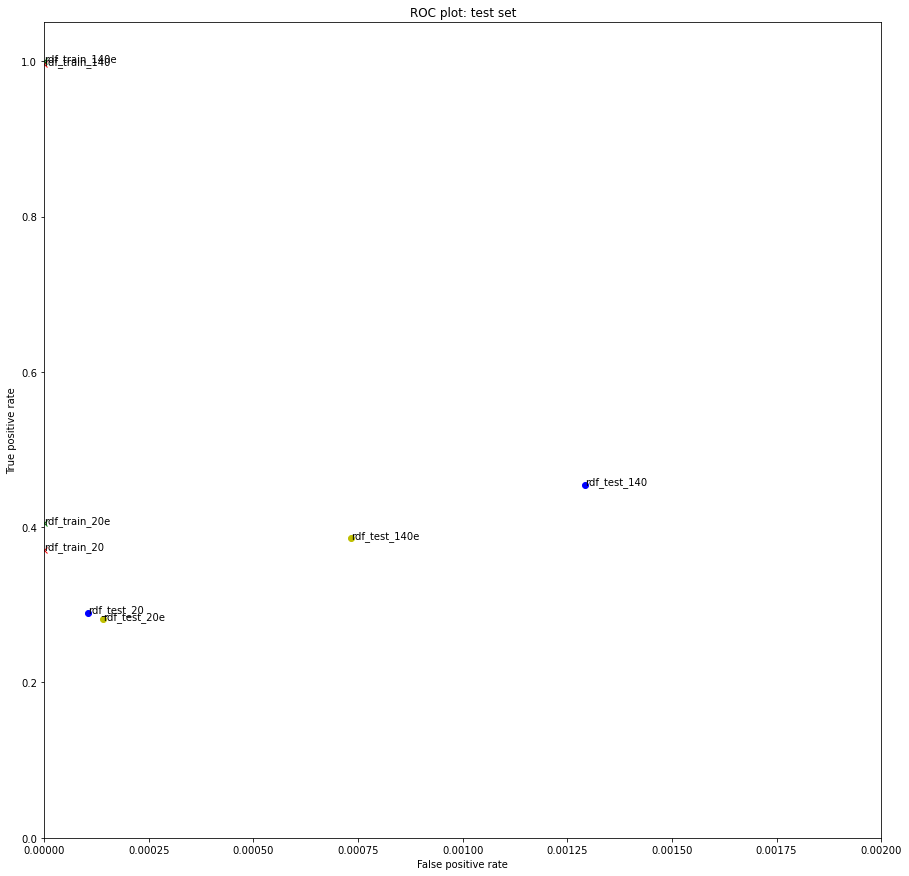

In [47]:
fits = [rdf_performance_test_20, rdf_performance_test_140]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
fits = [rdf_performance_test_20e, rdf_performance_test_140e]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'yo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
fits = [rdf_performance_train_20, rdf_performance_train_140]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'rx')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)  
    
fits = [rdf_performance_train_20e, rdf_performance_train_140e]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'gx')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc) 

plt.axis([0, 0.002, 0, 1.05])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.show()

### ROC plot to compare performance of various models and fits

In [ ]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, .125, 0.685, 0.79])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [ ]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.rcParams['figure.figsize'] = (15, 15)
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [258]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/Charles/Desktop/ML/A1/toxiccomments_test.csv', my_random_seed=36, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 5 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 16384)
Shape of HashingVectorizer char n_gram X:
(153164, 16384)
Look at a few rows of the new quantitative features: 
   word_count_h  word_count_s  word_count_f  punc_q_ratio  punc_exc_ratio  \
0             0             1             2      0.009009        0.009009   
1             0   

In [ ]:
# for 2 HashingV passed through respective tfidf transformer and then hstacked with quantfeat: AttributeError: lower not found
# for 2 HashingV hstacked and passed through tfidf transformer: TypeError: 'coo_matrix' object is not subscriptable

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [259]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = nbs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.2801637460499856


In [260]:
raw_data.head()

,id,comment_text,char_count,Caps_count,Caps_ratio,word_count,char_ratio,punc_count_p,punc_count_exc,punc_count_q,...,Capsword_ratio,spaces_count,spaces_ratio,spaceswords_ratio,consCaps_count,consCaps_ratio,consCapsword_ratio,word_count_f,word_count_s,word_count_h
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367,4,0.000003,72,5.097222,10,0,0,...,0.208333,71,0.193460,0.986111,0,0.00,0.000000,2,1,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50,7,0.004096,13,3.846154,1,0,0,...,0.692308,12,0.240000,0.923077,1,0.02,0.076923,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,4,0.000794,16,3.375000,0,0,0,...,0.312500,15,0.277778,0.937500,0,0.00,0.000000,0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",205,4,0.000015,38,5.394737,3,0,0,...,0.210526,37,0.180488,0.973684,0,0.00,0.000000,0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,41,1,0.000116,7,5.857143,1,0,0,...,0.285714,6,0.146341,0.857143,0,0.00,0.000000,0,0,0


In [92]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [261]:
my_submission.shape

(153164, 2)

In [262]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/Charles/Desktop/ML/A1/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation